In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# some data synthesized by adding Gaussian(Normal) noise to points along a line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000

# A vector of random x values
x = tf.random.normal(shape=[NUM_EXAMPLES])

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = x * TRUE_W + TRUE_B + noise

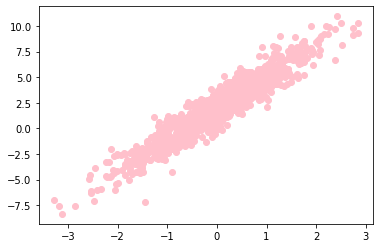

In [4]:
plt.scatter(x, y, c="pink")
plt.show()

In [5]:
# Define the model
class MyModel(tf.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs) # 将参数全部传过去
        self.w = tf.Variable(5.0)
        self.b = tf.Variable(0.0)
    
    def __call__(self, x):
        return self.w * x + self.b

model = MyModel()

print("Variables: ", model.variables)

Variables:  (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


In [8]:
# Verify the model works
assert model(3.0).numpy() == 15.0 # 没有报错

In [12]:
def loss(target_y, predicted_y):
    return tf.reduce_mean(tf.square(target_y - predicted_y))

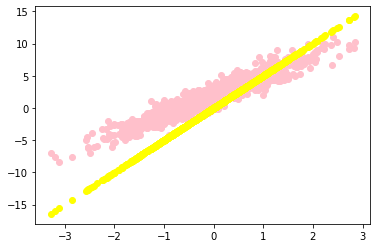

In [10]:
plt.scatter(x, y, c="pink")
plt.scatter(x, model(x), c = "yellow")
plt.show()

In [13]:
print("Current loss: %1.6f" % loss(y, model(x)).numpy())

Current loss: 9.122092


In [14]:
# Given a callable model, inputs, outputs, and a learning rate...
def train(model, x, y, learning_rate):

  with tf.GradientTape() as t:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(y, model(x))

  # Use GradientTape to calculate the gradients with respect to W and b
  dw, db = t.gradient(current_loss, [model.w, model.b])

  # Subtract the gradient scaled by the learning rate
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

In [15]:
model = MyModel()

# Collect the history of W-values and b-values to plot later
Ws, bs = [], []
epochs = range(10)

# Define a training loop
def training_loop(model, x, y):

  for epoch in epochs:
    # Update the model with the single giant batch
    train(model, x, y, learning_rate=0.1)

    # Track this before I update
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(y, model(x))

    print("Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f" %
          (epoch, Ws[-1], bs[-1], current_loss))

Starting: W=5.00 b=0.00, loss=9.12209
Epoch  0: W=4.59 b=0.41, loss=6.13177
Epoch  1: W=4.27 b=0.73, loss=4.24353
Epoch  2: W=4.01 b=0.99, loss=3.05117
Epoch  3: W=3.81 b=1.20, loss=2.29821
Epoch  4: W=3.65 b=1.36, loss=1.82270
Epoch  5: W=3.52 b=1.50, loss=1.52240
Epoch  6: W=3.42 b=1.60, loss=1.33275
Epoch  7: W=3.34 b=1.68, loss=1.21297
Epoch  8: W=3.28 b=1.75, loss=1.13731
Epoch  9: W=3.23 b=1.80, loss=1.08953


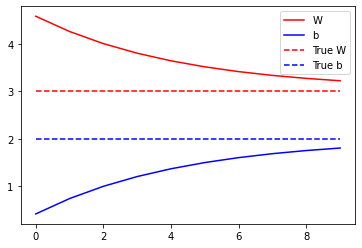

In [16]:
print("Starting: W=%1.2f b=%1.2f, loss=%2.5f" %
      (model.w, model.b, loss(y, model(x))))

# Do the training
training_loop(model, x, y)

# Plot it
plt.plot(epochs, Ws, "r",
         epochs, bs, "b")

plt.plot([TRUE_W] * len(epochs), "r--",
         [TRUE_B] * len(epochs), "b--")

plt.legend(["W", "b", "True W", "True b"])
plt.show()

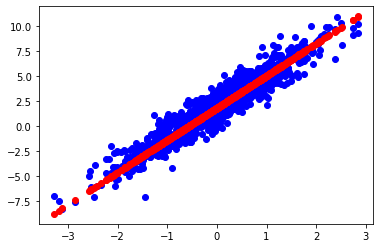

Current loss: 1.089530


In [17]:
# Visualize how the trained model performs
plt.scatter(x, y, c="b")
plt.scatter(x, model(x), c="r")
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy()) 

In [18]:
# same sloution but with keras
class MyModelKeras(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def call(self, x):
    return self.w * x + self.b

keras_model = MyModelKeras()

# Reuse the training loop with a Keras model
training_loop(keras_model, x, y)

# You can also save a checkpoint using Keras's built-in support
keras_model.save_weights("my_checkpoint")

Epoch  0: W=4.59 b=0.41, loss=6.13177
Epoch  1: W=4.27 b=0.73, loss=4.24353
Epoch  2: W=4.01 b=0.99, loss=3.05117
Epoch  3: W=3.81 b=1.20, loss=2.29821
Epoch  4: W=3.65 b=1.36, loss=1.82270
Epoch  5: W=3.52 b=1.50, loss=1.52240
Epoch  6: W=3.42 b=1.60, loss=1.33275
Epoch  7: W=3.34 b=1.68, loss=1.21297
Epoch  8: W=3.28 b=1.75, loss=1.13731
Epoch  9: W=3.23 b=1.80, loss=1.08953


In [19]:
keras_model = MyModelKeras()

# compile sets the training parameters
keras_model.compile(
    # By default, fit() uses tf.function().  You can
    # turn that off for debugging, but it is on now.
    run_eagerly=False,

    # Using a built-in optimizer, configuring as an object
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # Keras comes with built-in MSE error
    # However, you could use the loss function
    # defined above
    loss=tf.keras.losses.mean_squared_error,
)

In [20]:
print(x.shape[0])
keras_model.fit(x, y, epochs=10, batch_size=1000)

1000
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 9.1221
Epoch 2/10
1/1 [==============================] - 0s 1ms/step - loss: 6.1318
Epoch 3/10
1/1 [==============================] - 0s 1ms/step - loss: 4.2435
Epoch 4/10
1/1 [==============================] - 0s 665us/step - loss: 3.0512
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 2.2982
Epoch 6/10
1/1 [==============================] - 0s 1ms/step - loss: 1.8227
Epoch 7/10
1/1 [==============================] - 0s 1ms/step - loss: 1.5224
Epoch 8/10
1/1 [==============================] - 0s 1ms/step - loss: 1.3327
Epoch 9/10
1/1 [==============================] - 0s 1ms/step - loss: 1.2130
Epoch 10/10
1/1 [==============================] - 0s 1ms/step - loss: 1.1373
